In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import colors
import sdf
import re
import glob
import tqdm
plt.rcParams["font.size"] = 30
plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
SAVE_DIR = "../../Presentations/PPTs/Sem_3_Major/images"

# Plasma Density and Laser Intensity

## Parameters

In [3]:
D_DIR = "../High_Harmonic_Generation/harmonics"

In [4]:
m = 9.10938356e-31
e = 1.60217662e-19
c = 299792458
PI = np.pi
epsilon = 8.85e-12

In [5]:
DATA_DIR = os.path.join(D_DIR, "run1")
with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data=myfile.read()

The parameters which we want to extract are:
* Wavelength: `lambda`
* Laser Time: `las_time`
* Vector Potential: `a0`
* The density factor: `factor`
* Number of Cells: `nx`
* Simulation End Time: `t_end`
* Size of Box: `x_min`
* dt: `dt_snapshot`

In [6]:
def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None

In [7]:
LAMBD= find_value("lambda0")*1e-6
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("t_end"))
DT = find_value("dt_snapshot")*1e-15
A0 = find_value("a0")
FACTOR = int(find_value("factor"))
NX = int(find_value("nx"))
X_MIN = -int(find_value("x_min"))

print("Values from input.deck:")
print("lambda0 = ", LAMBD)
print("laser_time = ", LAS_TIME)
print("t_end = ", T_MAX)
print("dt_snapshot = ", DT)
print("a0 = ", A0)
print("factor = ", FACTOR)
print("nx = ", NX)
print("x_min = ", X_MIN)

Values from input.deck:
lambda0 =  1e-06
laser_time =  20
t_end =  40
dt_snapshot =  8e-17
a0 =  0.5
factor =  7
nx =  16000
x_min =  -20


In [8]:
omega0 = 2*PI*c/LAMBD
tau = 2*PI/omega0
nc = epsilon*m*omega0**2/e**2
Er = m * omega0 * c / e
n0 = FACTOR*nc
LAS_TIME = LAS_TIME*tau
print("Calculated Values for the simulation are:")
print("omega0 = ", omega0)
print("tau = ", tau)
print("nc = ", nc)
print("Er = ", Er)
print("n0 = ", n0)

Calculated Values for the simulation are:
omega0 =  1883651567308853.2
tau =  3.3356409519815205e-15
nc =  1.1143269197457677e+27
Er =  3210701072782.3525
n0 =  7.800288438220374e+27


In [9]:
omega_to_resolve = 20*omega0
f_max_to_resolve = omega_to_resolve/(2*PI)
dt_max_to_resolve = 1/(2*f_max_to_resolve)
print(f"The maximum time step for resolution is {dt_max_to_resolve*1e15} femto seconds")

The maximum time step for resolution is 0.08339102379953801 femto seconds


In [10]:
f_max = 1/(DT)
omega_max = 2*np.pi*f_max
omega_max/omega0

41.69551189976901

In [11]:
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
len(ALL_FILES)

0

In [12]:
X = np.linspace(X_MIN, -X_MIN, NX)
T = np.linspace(0, T_MAX, len(ALL_FILES))

## Harmonics

In [13]:
Et = np.zeros(len(ALL_FILES))
for i in tqdm.tqdm(range(len(ALL_FILES)), desc="Getting Data..."):
    data = sdf.read(ALL_FILES[i])
    ey = data.Electric_Field_Ey.data
    Et[i] = ey[8000]

Getting Data...: 100%|██████████| 1669/1669 [00:05<00:00, 331.47it/s]


In [14]:
Et = Et/np.max(Et)
y = np.fft.fft(Et)

In [15]:
y_shift = np.fft.fftshift(y)
y_f = np.abs(y_shift)

In [16]:
omega = np.linspace(-omega_max/2, omega_max/2, len(ALL_FILES))

In [17]:
omega_max/omega0

41.69551189976901

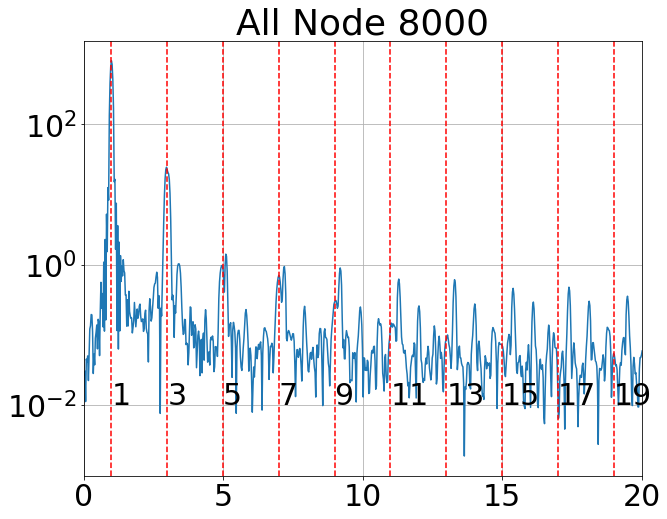

In [18]:
plt.plot(omega/omega0, 2*np.abs(y_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()
plt.title("All Node 8000");

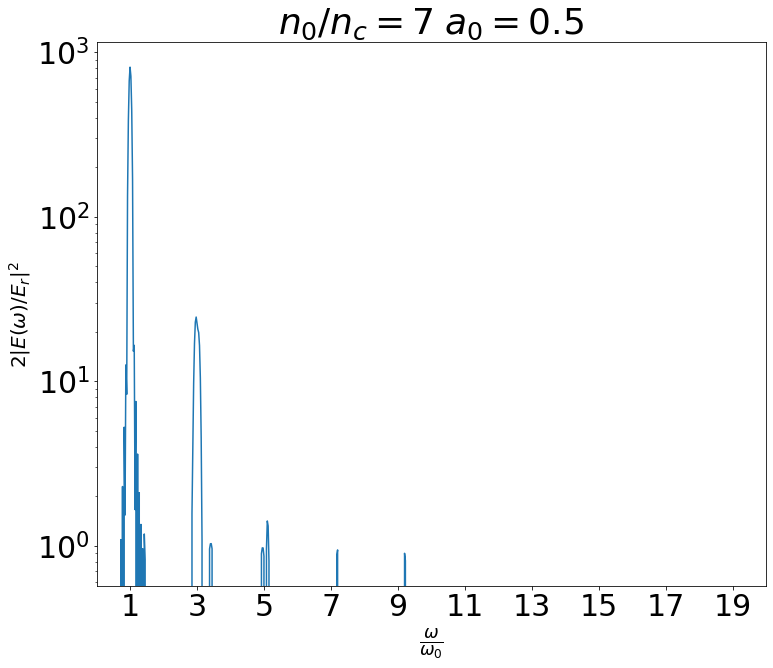

In [19]:
y2 = 2*np.abs(y_f)*2
mask = y2<0.8
y2[mask] = 0
font_dict = {
    'fontsize' : 20
}
plt.figure(figsize=(12,10))
plt.plot(omega/omega0, y2)
plt.yscale("log")
points = np.arange(1,21,2)
plt.xticks(points)
plt.xlim(0,20)
plt.title(rf"$n_0/n_c={FACTOR}\;a_0={A0}$")
plt.ylabel(r"$2|E(\omega)/E_r|^2$", fontdict={
    'fontsize' : 20
})
plt.xlabel(r"$\frac{\omega}{\omega_0}$", fontdict={
    'fontsize' : 25
})
file_name = DATA_DIR.split("/")[-1]+".jpg"
plt.savefig(file_name)
# plt.grid()

In [20]:
def plot_fft(directory, ax=None, style="-", **kwargs):
    DATA_DIR = os.path.join(D_DIR, directory)
    with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
        data=myfile.read()
    def find_value(info):
        regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
        match = regex.search(data)
        if match:
            return float(match.group(1))
        else:
            return None
    LAMBD= find_value("lambda0")*1e-6
    LAS_TIME = int(find_value("las_time"))
    T_MAX = int(find_value("t_end"))
    DT = find_value("dt_snapshot")*1e-15
    A0 = find_value("a0")
    FACTOR = int(find_value("factor"))
    NX = int(find_value("nx"))
    X_MIN = -int(find_value("x_min"))

    omega0 = 2*PI*c/LAMBD
    tau = 2*PI/omega0
    nc = epsilon*m*omega0**2/e**2
    Er = m * omega0 * c / e
    n0 = FACTOR*nc
    LAS_TIME = LAS_TIME*tau
    ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
    ALL_FILES.sort()

    X = np.linspace(X_MIN, -X_MIN, NX)
    T = np.linspace(0, T_MAX, len(ALL_FILES))

    Et = np.zeros(len(ALL_FILES))
    for i in tqdm.tqdm(range(len(ALL_FILES)), desc="Getting Data..."):
        data = sdf.read(ALL_FILES[i])
        ey = data.Electric_Field_Ey.data
        Et[i] = ey[8000]
    
    Et = Et/np.max(Et)
    y = np.fft.fft(Et)
    y_shift = np.fft.fftshift(y)
    y_f = np.abs(y_shift)
    omega = np.linspace(-omega_max/2, omega_max/2, len(ALL_FILES))

    y2 = 2*np.abs(y_f)*2
    mask = y2<0.8
    y2[mask] = 0
    if ax:
    # fig, ax = plt.subplots(figsize=(12,10))
        ax.plot(omega/omega0, y2, style, **kwargs)
        ax.set_yscale("log")
        points = np.arange(1,20,2)
        ax.set_xticks(points)
        ax.set_xlim(0,20)
        ax.set_title(rf"$n_0/n_c={FACTOR}\;a_0={A0}$")
        # ax.set_lege
        ax.set_ylabel(r"$2|E(\omega)/E_r|^2$")
        ax.set_xlabel(r"$\frac{\omega}{\omega_0}$", fontdict={
            'fontsize' : 35
        })
    else:
        plt.plot(omega/omega0, y2, style, label=rf"$n_0/n_c={FACTOR}\;a_0={A0}$", **kwargs)
        plt.yscale("log")
        points = np.arange(1,20,2)
        plt.xticks(points)
        plt.xlim(0,20)
        # plt.title()
        plt.ylabel(r"$2|E(\omega)/E_r|^2$")
        plt.xlabel(r"$\frac{\omega}{\omega_0}$", fontdict={
            'fontsize' : 35
        })

Getting Data...: 100%|██████████| 1669/1669 [00:01<00:00, 941.50it/s]


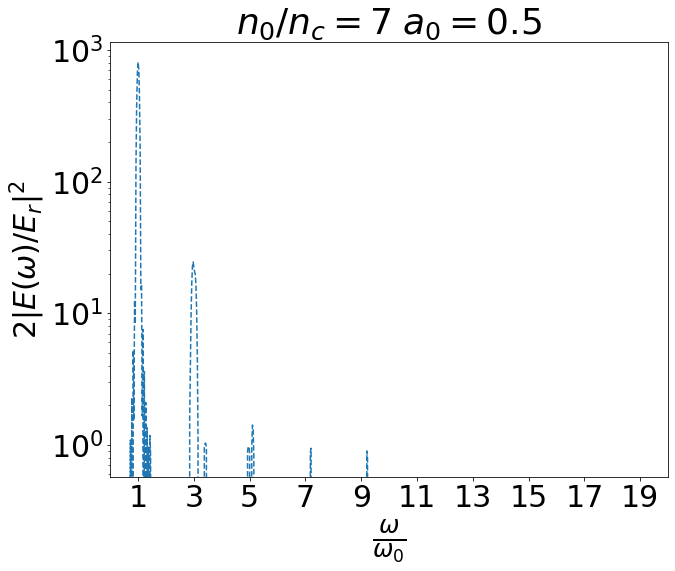

In [52]:
plot_fft("run1", plt.gca(), style="--")

Getting Data...: 100%|██████████| 1669/1669 [00:02<00:00, 569.90it/s]


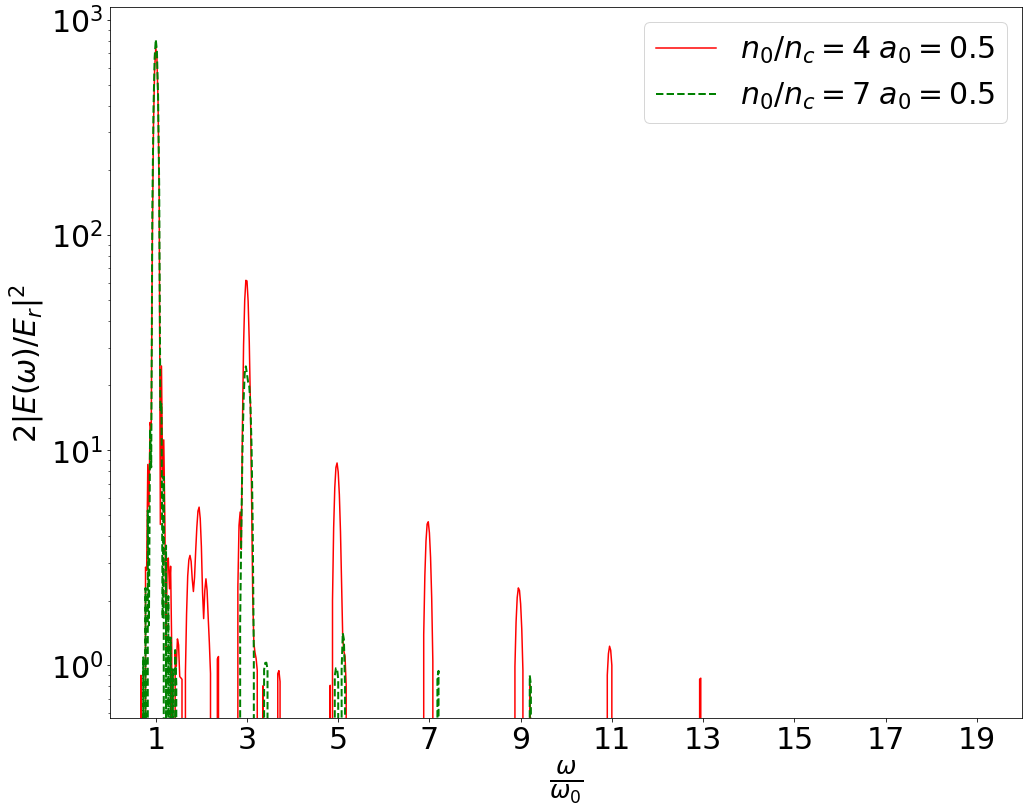

In [21]:
fig, ax = plt.subplots(1,1, figsize=(15,12))
plot_fft("run2", c="r")
plot_fft("run1", style="--", lw=2, c="g")
fig.tight_layout()
plt.legend()
file_name = "density2.jpg"
fig.savefig(os.path.join(SAVE_DIR, file_name), dpi=200)

Getting Data...: 100%|██████████| 1669/1669 [00:01<00:00, 1264.87it/s]


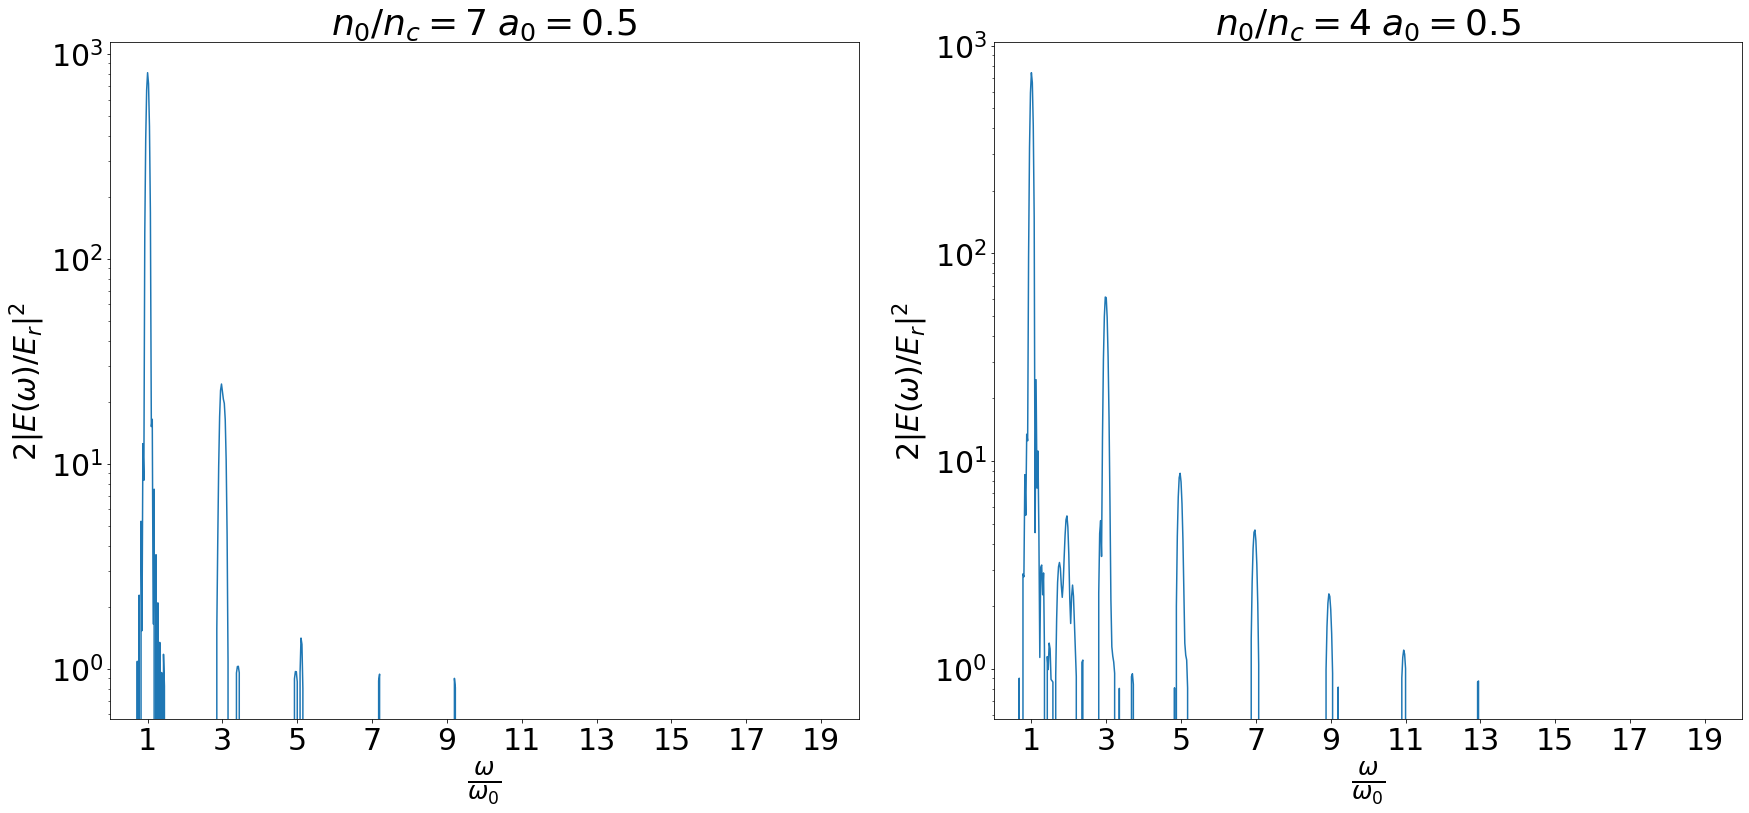

In [59]:
fig, axes = plt.subplots(1,2, figsize=(25,12))
plot_fft("run1", axes[0])
plot_fft("run2", axes[1])
fig.tight_layout()
# file_name = "density.jpg"
# fig.savefig(os.path.join(SAVE_DIR, file_name), dpi=200)

Getting Data...: 100%|██████████| 1669/1669 [00:02<00:00, 720.84it/s]


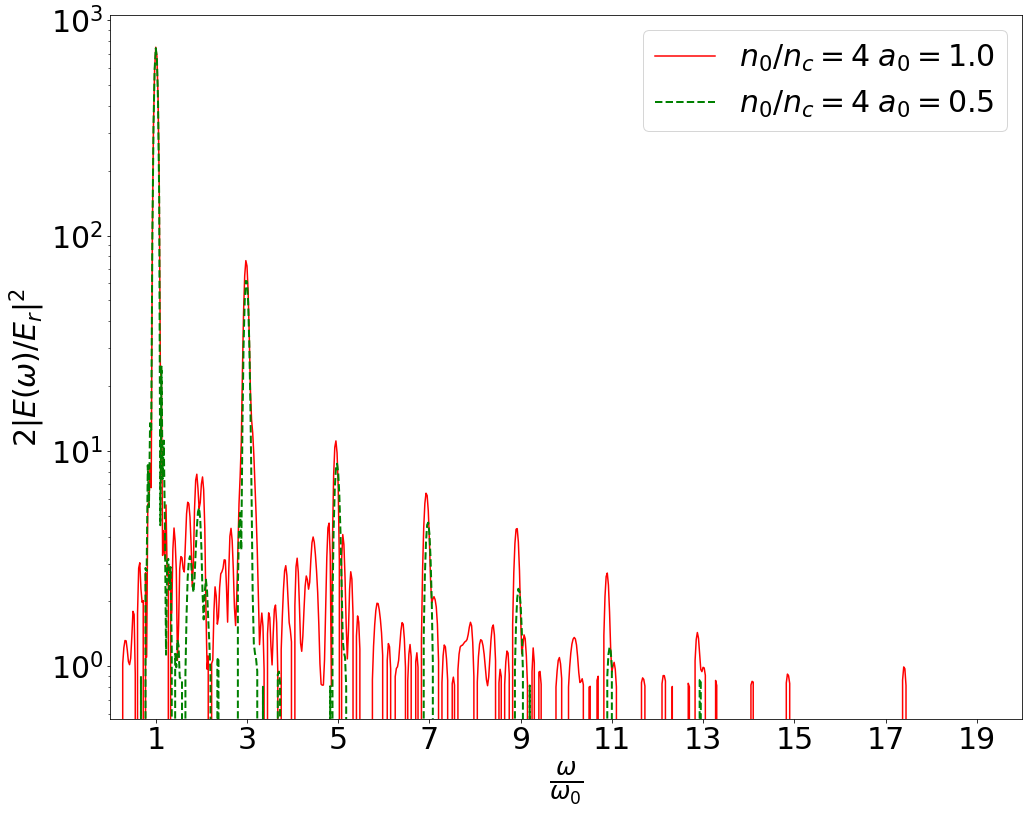

In [66]:
fig, ax = plt.subplots(1,1, figsize=(15,12))
plot_fft("run3", c="r")
plot_fft("run2", style="--", lw=2, c="g")
fig.tight_layout()
plt.legend()
file_name = "intensity2.jpg"
fig.savefig(os.path.join(SAVE_DIR, file_name), dpi=200)

Getting Data...: 100%|██████████| 1669/1669 [00:04<00:00, 409.31it/s]


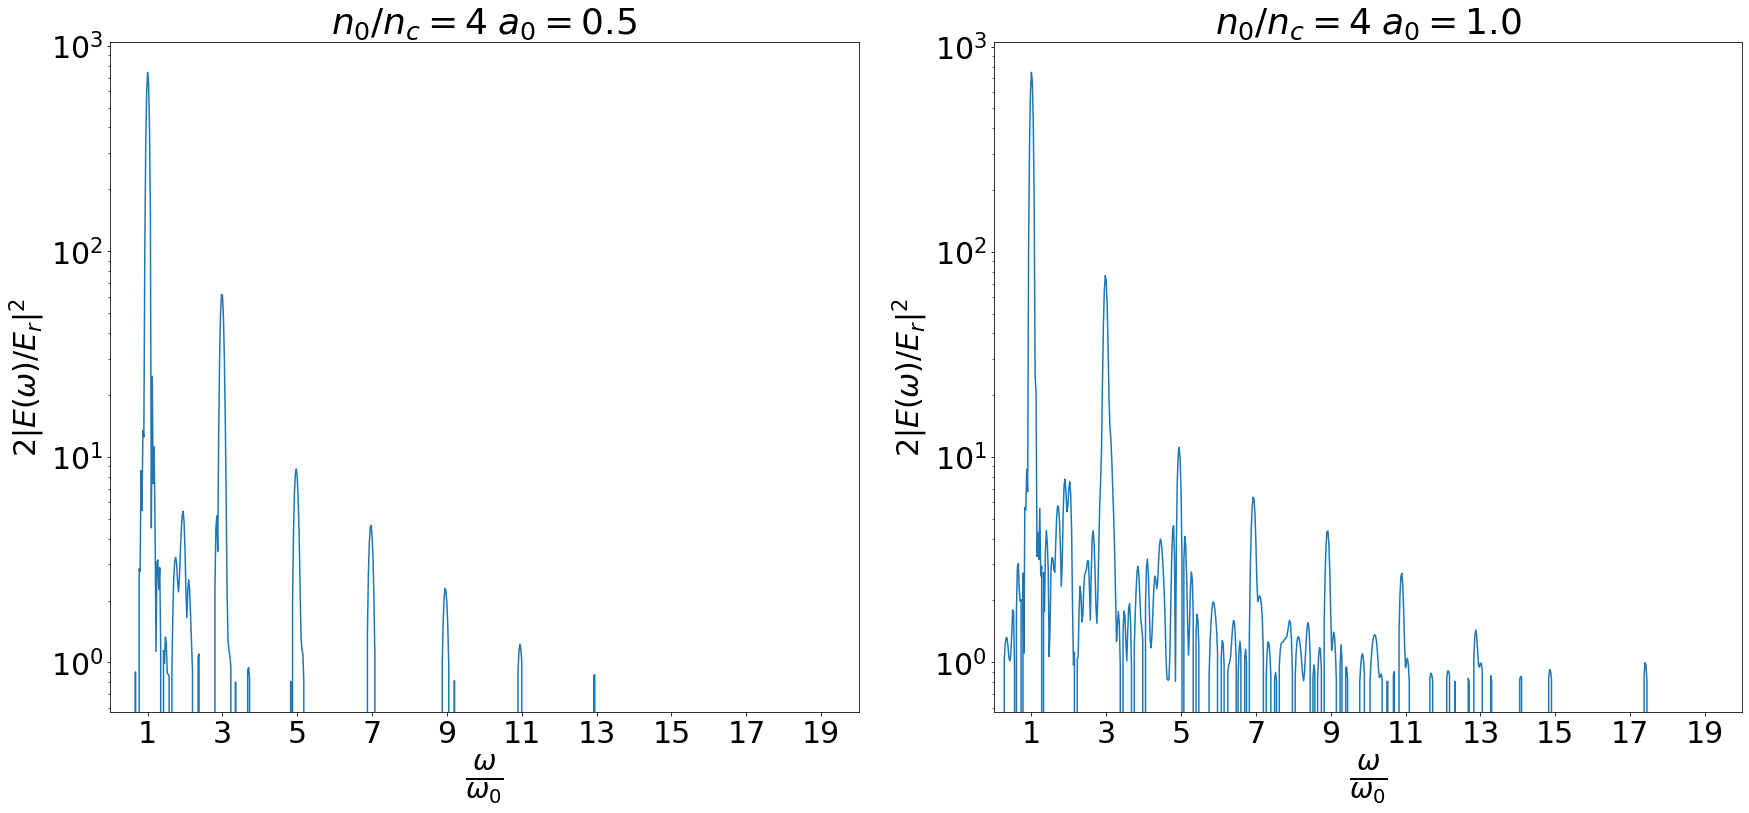

In [31]:
fig, axes = plt.subplots(1,2, figsize=(25,12))
plot_fft("run2", axes[0])
plot_fft("run3", axes[1])
fig.tight_layout()
file_name = "intensity.jpg"
fig.savefig(os.path.join(SAVE_DIR, file_name), dpi=200)

Getting Data...: 100%|██████████| 1669/1669 [00:01<00:00, 920.77it/s] 


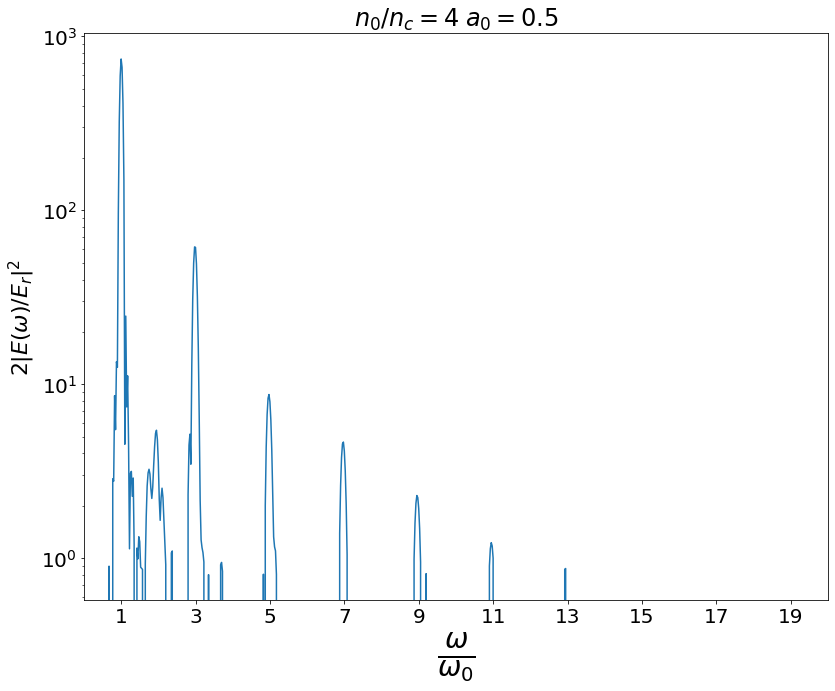

In [105]:
fig, ax = plt.subplots(figsize=(12,10))
plot_fft("run2", ax)
fig.tight_layout()
file_name = "base.jpg"
fig.savefig(os.path.join(SAVE_DIR, file_name), dpi=200)

## Density Oscillation

In [13]:
D_DIR = "../High_Harmonic_Generation/harmonics"

In [14]:
m = 9.10938356e-31
e = 1.60217662e-19
c = 299792458
PI = np.pi
epsilon = 8.85e-12

In [15]:
DATA_DIR = os.path.join(D_DIR, "run3")
with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data=myfile.read()

The parameters which we want to extract are:
* Wavelength: `lambda`
* Laser Time: `las_time`
* Vector Potential: `a0`
* The density factor: `factor`
* Number of Cells: `nx`
* Simulation End Time: `t_end`
* Size of Box: `x_min`
* dt: `dt_snapshot`

In [16]:
def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None

In [17]:
LAMBD= find_value("lambda0")*1e-6
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("t_end"))
DT = find_value("dt_snapshot")*1e-15
A0 = find_value("a0")
FACTOR = int(find_value("factor"))
NX = int(find_value("nx"))
X_MIN = -int(find_value("x_min"))

print("Values from input.deck:")
print("lambda0 = ", LAMBD)
print("laser_time = ", LAS_TIME)
print("t_end = ", T_MAX)
print("dt_snapshot = ", DT)
print("a0 = ", A0)
print("factor = ", FACTOR)
print("nx = ", NX)
print("x_min = ", X_MIN)

Values from input.deck:
lambda0 =  1e-06
laser_time =  20
t_end =  40
dt_snapshot =  8e-17
a0 =  1.0
factor =  4
nx =  16000
x_min =  -20


In [18]:
omega0 = 2*PI*c/LAMBD
tau = 2*PI/omega0
nc = epsilon*m*omega0**2/e**2
Er = m * omega0 * c / e
n0 = FACTOR*nc
LAS_TIME = LAS_TIME*tau
print("Calculated Values for the simulation are:")
print("omega0 = ", omega0)
print("tau = ", tau)
print("nc = ", nc)
print("Er = ", Er)
print("n0 = ", n0)

Calculated Values for the simulation are:
omega0 =  1883651567308853.2
tau =  3.3356409519815205e-15
nc =  1.1143269197457677e+27
Er =  3210701072782.3525
n0 =  4.457307678983071e+27


In [19]:
omega_to_resolve = 20*omega0
f_max_to_resolve = omega_to_resolve/(2*PI)
dt_max_to_resolve = 1/(2*f_max_to_resolve)
print(f"The maximum time step for resolution is {dt_max_to_resolve*1e15} femto seconds")

The maximum time step for resolution is 0.08339102379953801 femto seconds


In [20]:
f_max = 1/(DT)
omega_max = 2*np.pi*f_max
omega_max/omega0

41.69551189976901

In [21]:
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
len(ALL_FILES)

0

In [52]:
X = np.linspace(X_MIN, -X_MIN, NX)
T = np.linspace(0, T_MAX, len(ALL_FILES))

In [53]:
d = np.zeros((len(ALL_FILES), NX))
for i in tqdm.tqdm(range(len(ALL_FILES)), desc="Getting Data..."):
    data = sdf.read(ALL_FILES[i])
    d[i] = data.Derived_Number_Density_Electron.data

Getting Data...: 100%|██████████| 1669/1669 [00:04<00:00, 396.11it/s]


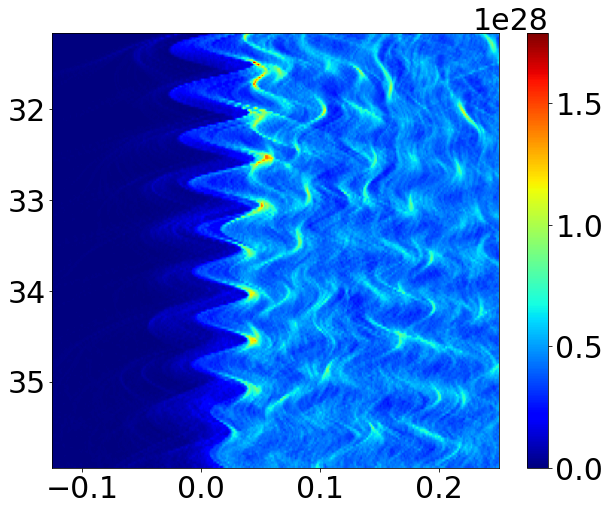

In [54]:
t_start = 1300
t_end = 1500
t_max = d.shape[0]
x_max = d.shape[1]
x_start = 2*3950
x_end = 2*4100
EXTENT = [-X_MIN*(x_start-NX//2)/x_max,-X_MIN*(x_end-NX//2)/x_max,T_MAX*t_end/t_max,T_MAX*t_start/t_max]
plt.imshow(d[t_start:t_end, x_start:x_end], aspect="auto", extent=EXTENT, cmap="jet")
cmap = colors.ListedColormap(["white", "black"])
plt.colorbar(cmap=cmap)

In [22]:
def plot_density(DATA_DIR, ax, a0=0.5):
    dir_ = os.path.join(D_DIR, DATA_DIR)
    ALL_FILES = glob.glob(f"{dir_}/*sdf")
    ALL_FILES.sort()
    if len(ALL_FILES) == 0:
        print("No files found")
        return
    X = np.linspace(X_MIN, -X_MIN, NX)
    T = np.linspace(0, T_MAX, len(ALL_FILES))
    d = np.zeros((len(ALL_FILES), NX))
    for i in tqdm.tqdm(range(len(ALL_FILES)), desc="Getting Data..."):
        data = sdf.read(ALL_FILES[i])
        d[i] = data.Derived_Number_Density_Electron.data
    d = d/nc
    t_start = 1200
    t_end = 1400
    t_max = d.shape[0]
    x_max = d.shape[1]
    x_start = 2*3950
    x_end = 2*4100
    EXTENT = [-X_MIN*(x_start-NX//2)/x_max,-X_MIN*(x_end-NX//2)/x_max,T_MAX*t_end/t_max,T_MAX*t_start/t_max]
    ax.imshow(d[t_start:t_end, x_start:x_end], aspect="auto", extent=EXTENT, cmap="jet")
    cmap = colors.ListedColormap(["white", "black"])
    ax.set_title(rf"$n_0/n_c=7\;a_0={a0}$")
    ax.set_ylabel(r"$\frac{t}{\tau}$", fontdict={
        'fontsize' : 50
    })
    ax.set_xlabel(r"$\frac{x}{\lambda_0}$", fontdict={
        'fontsize' : 40
    })
    # add cmap
    return cmap

    # file_name = DATA_DIR.split("/")[-1]+".jpg"
    # plt.savefig(file_name)
    # plt.show()

Getting Data...: 100%|██████████| 1669/1669 [00:01<00:00, 956.27it/s] 


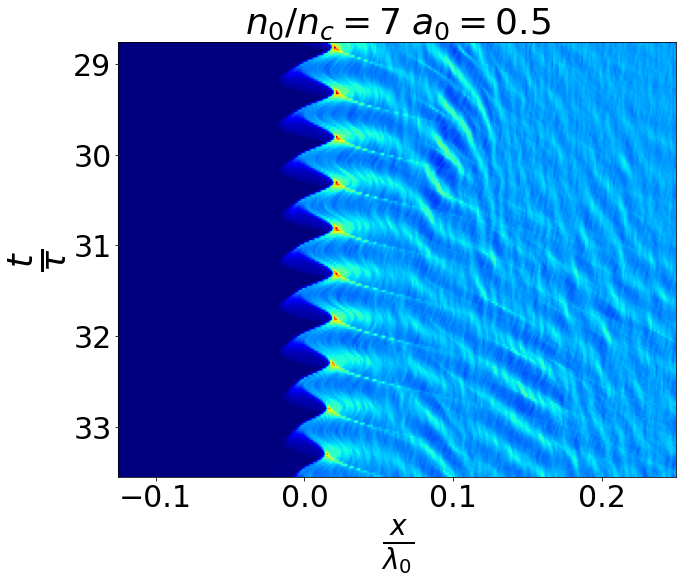

In [61]:
cmap = plot_density("run4", plt.gca())

Getting Data...: 100%|██████████| 1669/1669 [00:01<00:00, 1004.97it/s]


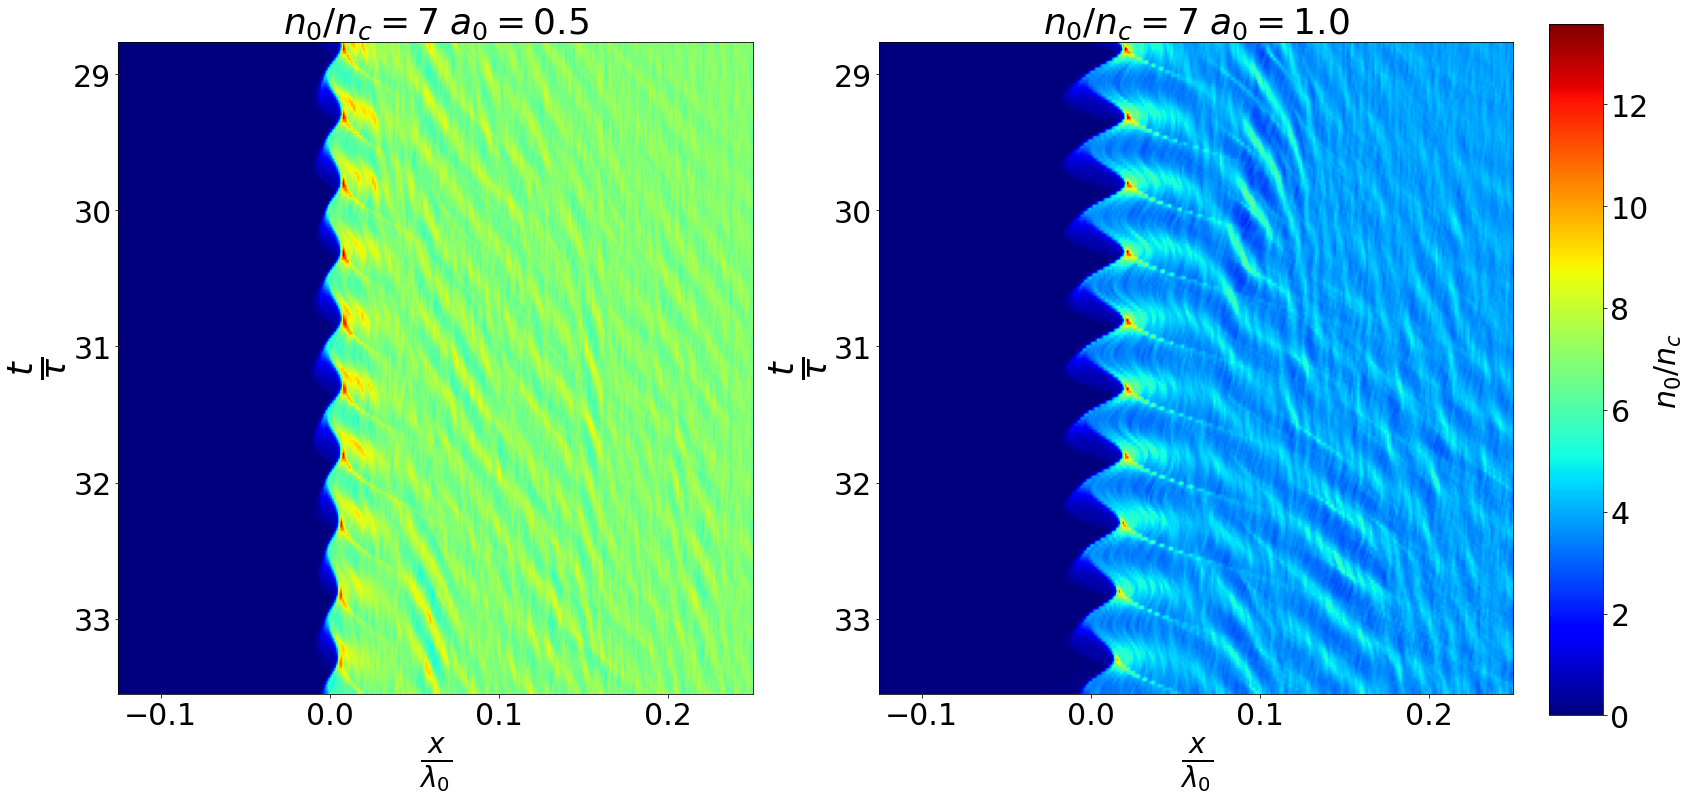

In [62]:
fig, axes = plt.subplots(1,2, figsize=(25,12))
plot_density("run1", axes[0], 0.5)
plot_density("run4", axes[1], 1.0)
#add colorbar
# fig.subplots_adjust(right=0.8)
# cmap = colors.ListedColormap(["white", "black"])
cax = fig.add_axes([0.92, 0.1, 0.03, 0.8])
fig.colorbar(axes[0].images[0], cax=cax, label=r"$n_0/n_c$", orientation="vertical")
# fig.tight_layout()
file_name = "oscillation1.jpg"
fig.savefig(os.path.join(SAVE_DIR, file_name), dpi=200)

# Envelopes

In [26]:
D_DIR = "../High_Harmonic_Generation/envelopes"

In [36]:
def plot_fft(directory, ax=None, **kwargs):
    DATA_DIR = os.path.join(D_DIR, directory)
    with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
        data=myfile.read()
    # print(DATA_DIR)
    def find_value(info):
        regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
        match = regex.search(data)
        if match:
            return float(match.group(1))
        else:
            return None
    LAMBD= find_value("lambda0")*1e-6
    LAS_TIME = int(find_value("las_time"))
    T_MAX = int(find_value("t_end"))
    DT = find_value("dt_snapshot")*1e-15
    A0 = find_value("a0")
    FACTOR = int(find_value("factor"))
    NX = int(find_value("nx"))
    X_MIN = -int(find_value("x_min"))

    omega0 = 2*PI*c/LAMBD
    tau = 2*PI/omega0
    nc = epsilon*m*omega0**2/e**2
    Er = m * omega0 * c / e
    n0 = FACTOR*nc
    LAS_TIME = LAS_TIME*tau
    ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
    ALL_FILES.sort()

    X = np.linspace(X_MIN, -X_MIN, NX)
    T = np.linspace(0, T_MAX, len(ALL_FILES))

    Et = np.zeros(len(ALL_FILES))
    for i in tqdm.tqdm(range(len(ALL_FILES)), desc="Getting Data..."):
        data = sdf.read(ALL_FILES[i])
        ey = data.Electric_Field_Ey.data
        Et[i] = ey[8000]
    
    Et = Et/np.max(Et)
    y = np.fft.fft(Et)
    y_shift = np.fft.fftshift(y)
    y_f = np.abs(y_shift)
    omega = np.linspace(-omega_max/2, omega_max/2, len(ALL_FILES))

    y2 = 2*np.abs(y_f)*2
    mask = y2<0.8
    y2[mask] = 0
    font_dict = {
        'fontsize' : 25
    }
    if ax:
    # fig, ax = plt.subplots(figsize=(12,10))
        ax.plot(omega/omega0, y2, **kwargs)
        ax.set_yscale("log")
        points = np.arange(1,20,2)
        ax.set_xticks(points)
        ax.set_xlim(0,20)
        directory = directory.replace("_", " ")
        ax.set_title(f"{directory.title()} Envelope")
        ax.set_ylabel(r"$2|E(\omega)/E_r|^2$", fontdict={
            'fontsize' : 30
        })
        ax.set_xlabel(r"$\frac{\omega}{\omega_0}$", fontdict={
            'fontsize' : 40
        })
        file_name = DATA_DIR.split("/")[-1]+".jpg"
    # plt.savefig(file_name)
    # plt.show()
    else:
        directory = directory.replace("_", " ")
        plt.plot(omega/omega0, y2, label = f"{directory.title()} Envelope", **kwargs)
        plt.yscale("log")
        points = np.arange(1,20,2)
        plt.xticks(points)
        plt.xlim(0,20)
        
        # plt.title(f"{directory.title()} Envelope")
        plt.ylabel(r"$2|E(\omega)/E_r|^2$", fontdict={
            'fontsize' : 30
        })
        plt.xlabel(r"$\frac{\omega}{\omega_0}$", fontdict={
            'fontsize' : 40
        })


Getting Data...: 100%|██████████| 1669/1669 [00:01<00:00, 933.19it/s] 


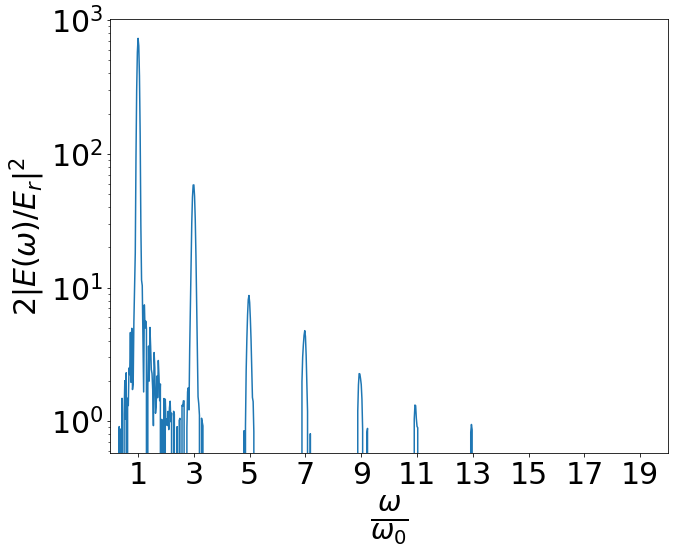

In [33]:
plot_fft("gaussian")

Getting Data...: 100%|██████████| 1669/1669 [00:01<00:00, 1124.78it/s]


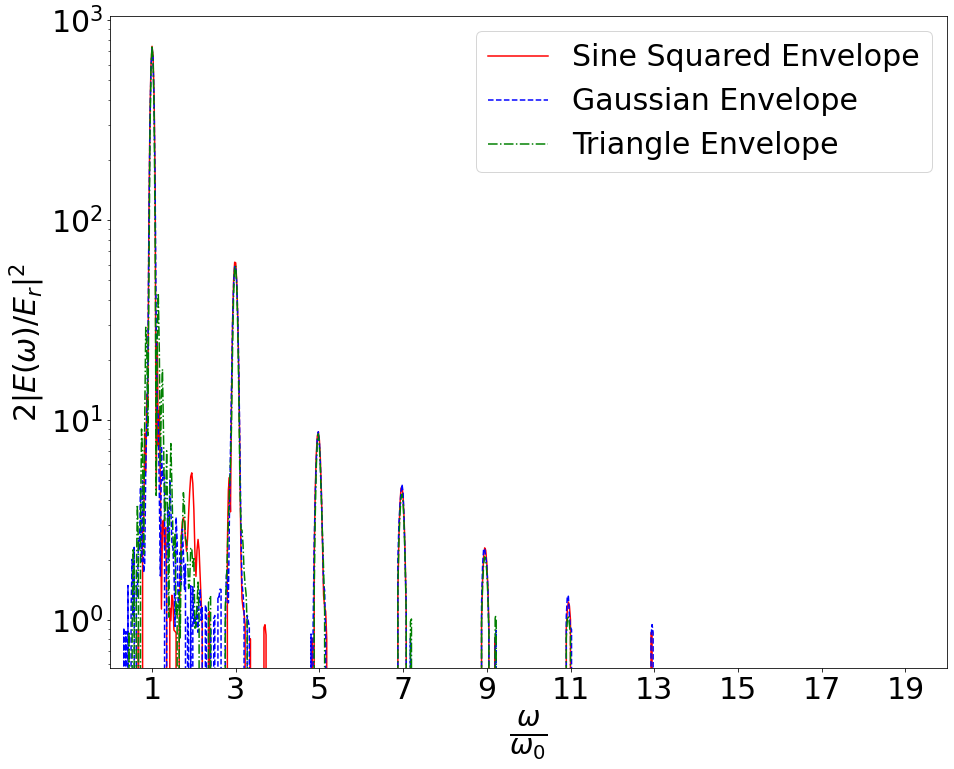

In [50]:
fig = plt.figure(figsize=(15,12))
dirs = ["sine_squared", "gaussian", "triangle"]
more_args = [
    {
        "color" : "red",
        "linestyle" : "-",
        # "alpha": 0.5
    },
    {
        "color" : "blue",
        "linestyle" : "--",
        # "alpha": 0.5
    },
    {
        "color" : "green",
        "linestyle" : "-.",
        # "alpha": 0.5
    }
]
for dir in dirs:
    plot_fft(dir, **more_args.pop(0))
plt.legend()
file_name = "env2.jpg"
fig.savefig(os.path.join(SAVE_DIR, file_name), dpi=200)

Getting Data...: 100%|██████████| 1669/1669 [00:01<00:00, 920.08it/s] 


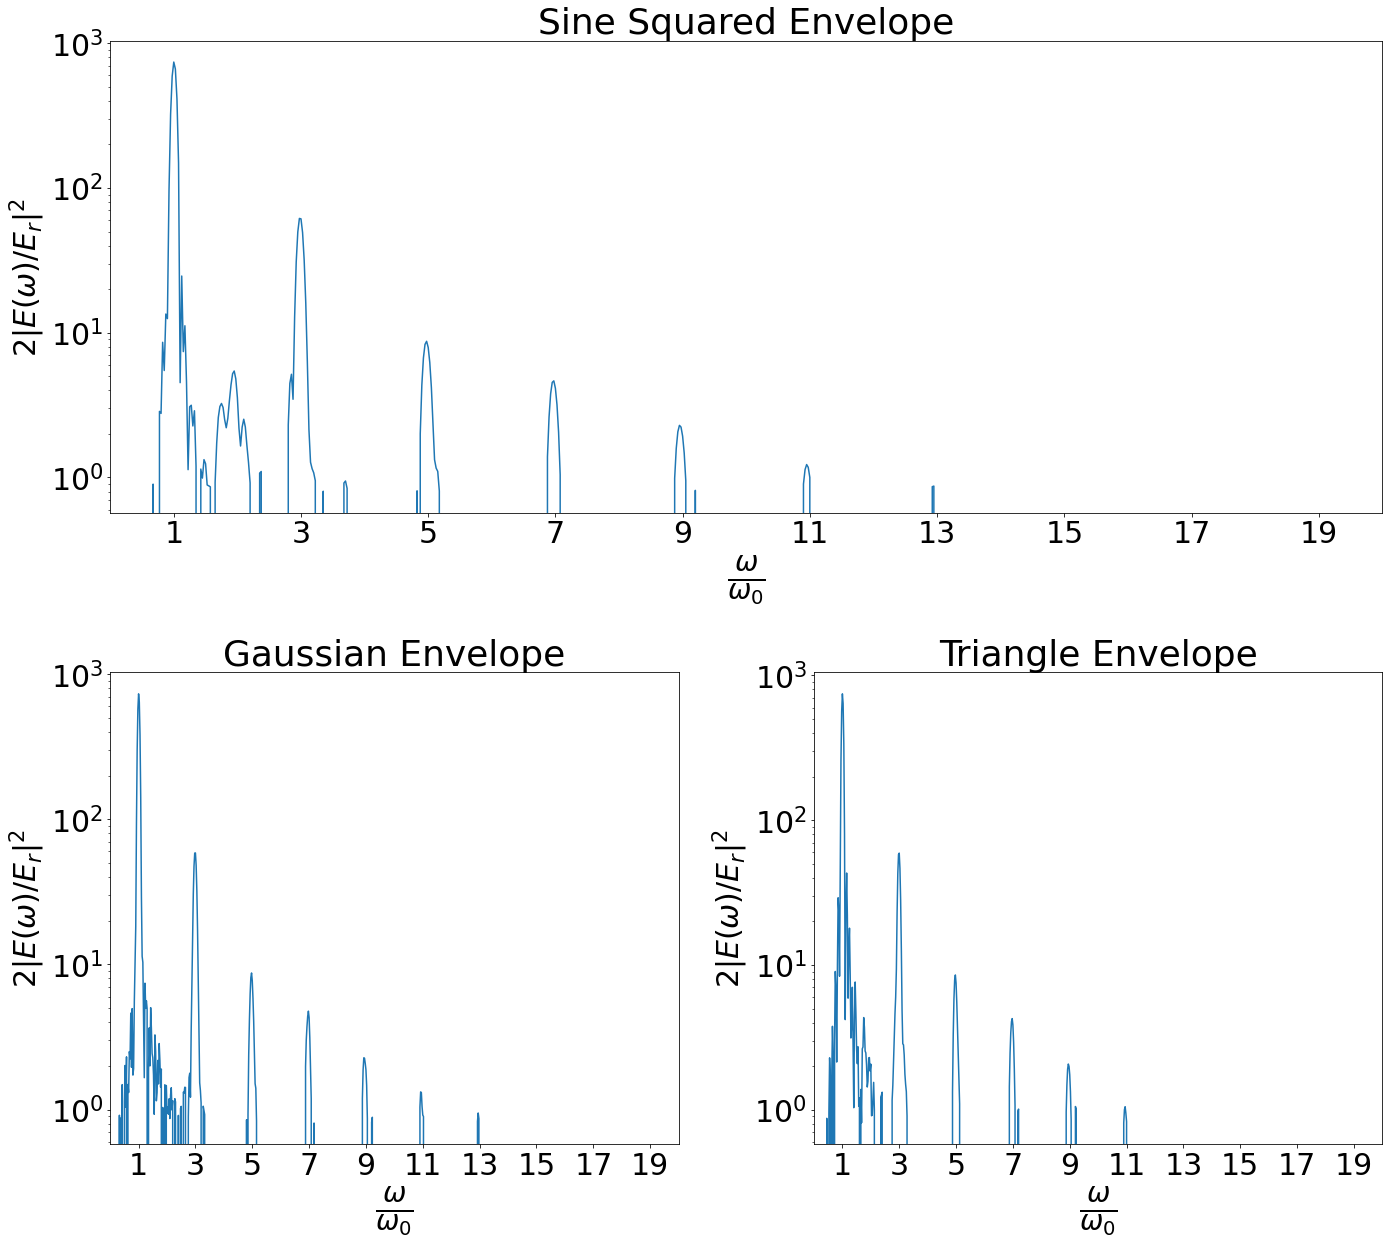

In [45]:
fig = plt.figure(figsize=(20,18))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
dirs = ["sine_squared", "gaussian", "triangle"]
for i, dir in enumerate(dirs):
    plot_fft(dir, ax1 if i==0 else ax2 if i==1 else ax3)
fig.tight_layout()
# file_name = "env.jpg"
# fig.savefig(os.path.join(SAVE_DIR, file_name), dpi=200)

# Pulse Duration

In [39]:
def plot_fft(directory, ax):
    DATA_DIR = os.path.join(D_DIR, directory)
    with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
        data=myfile.read()
    # print(DATA_DIR)
    def find_value(info):
        regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
        match = regex.search(data)
        if match:
            return float(match.group(1))
        else:
            return None
    LAMBD= find_value("lambda0")*1e-6
    LAS_TIME = int(find_value("las_time"))
    T_MAX = int(find_value("t_end"))
    DT = find_value("dt_snapshot")*1e-15
    A0 = find_value("a0")
    FACTOR = int(find_value("factor"))
    NX = int(find_value("nx"))
    X_MIN = -int(find_value("x_min"))

    omega0 = 2*PI*c/LAMBD
    tau = 2*PI/omega0
    nc = epsilon*m*omega0**2/e**2
    Er = m * omega0 * c / e
    n0 = FACTOR*nc
    LAS_TIME = LAS_TIME*tau
    ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
    ALL_FILES.sort()

    X = np.linspace(X_MIN, -X_MIN, NX)
    T = np.linspace(0, T_MAX, len(ALL_FILES))

    Et = np.zeros(len(ALL_FILES))
    for i in tqdm.tqdm(range(len(ALL_FILES)), desc="Getting Data..."):
        data = sdf.read(ALL_FILES[i])
        ey = data.Electric_Field_Ey.data
        Et[i] = ey[8000]
    
    Et = Et/np.max(Et)
    y = np.fft.fft(Et)
    y_shift = np.fft.fftshift(y)
    y_f = np.abs(y_shift)
    omega = np.linspace(-omega_max/2, omega_max/2, len(ALL_FILES))

    y2 = 2*np.abs(y_f)*2
    mask = y2<0.6
    y2[mask] = 0
    font_dict = {
        'fontsize' : 25
    }
    # fig, ax = plt.subplots(figsize=(12,10))
    ax.plot(omega/omega0, y2)
    ax.set_yscale("log")
    points = np.arange(1,20,2)
    ax.set_xticks(points)
    ax.set_xlim(0,20)
    directory = directory.split("_")[-1]
    ax.set_title(f"{directory} $\\tau$")
    ax.set_ylabel(r"$2|E(\omega)/E_r|^2$", fontdict={
        'fontsize' : 30
    })
    ax.set_xlabel(r"$\frac{\omega}{\omega_0}$", fontdict={
        'fontsize' : 40
    })
    file_name = DATA_DIR.split("/")[-1]+".jpg"
    # plt.savefig(file_name)
    # plt.show()


In [40]:
D_DIR = "../High_Harmonic_Generation/pulse_duration"

Getting Data...: 100%|██████████| 1669/1669 [00:04<00:00, 372.07it/s]


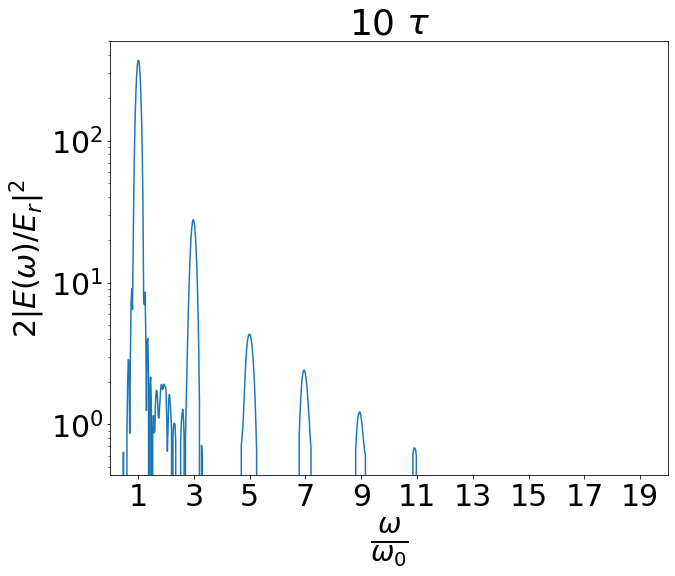

In [41]:
plot_fft("tau_10", plt.gca())

Getting Data...: 100%|██████████| 2503/2503 [00:06<00:00, 398.79it/s]


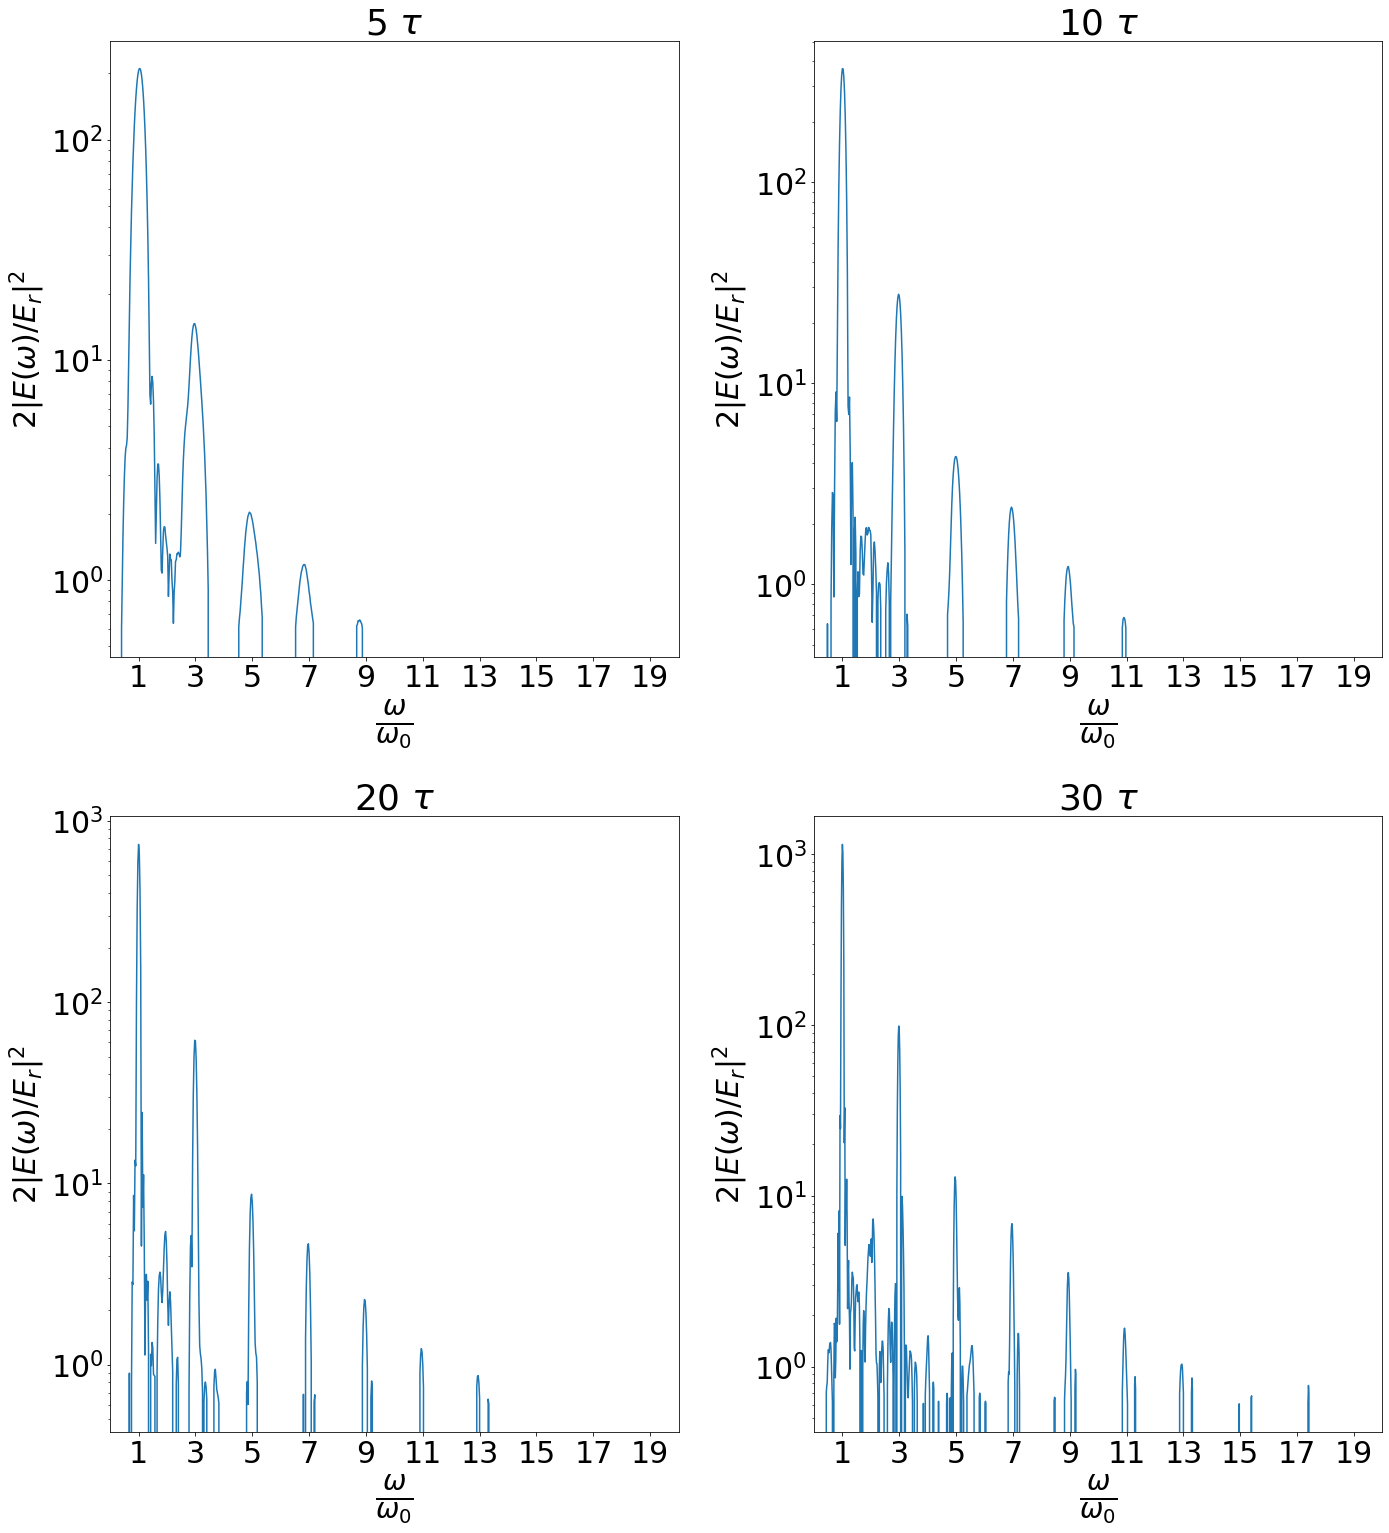

In [42]:
dirs = ["tau_5", "tau_10", "tau_20", "tau_30"]
fig, axes = plt.subplots(2,2, figsize=(20,22))
for i, dir in enumerate(dirs):
    plot_fft(dir, axes[i//2, i%2])
# fig.suptitle("Pulse Duration", fontsize=40)
fig.tight_layout()
file_name = "pulse.jpg"
fig.savefig(os.path.join(SAVE_DIR, file_name), dpi=200)

# Others

In [4]:
D_DIR = "../High_Harmonic_Generation/harmonics"
DATA_DIR = os.path.join(D_DIR, "run1")
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
len(ALL_FILES)

1669

In [16]:
data = sdf.read(ALL_FILES[0])

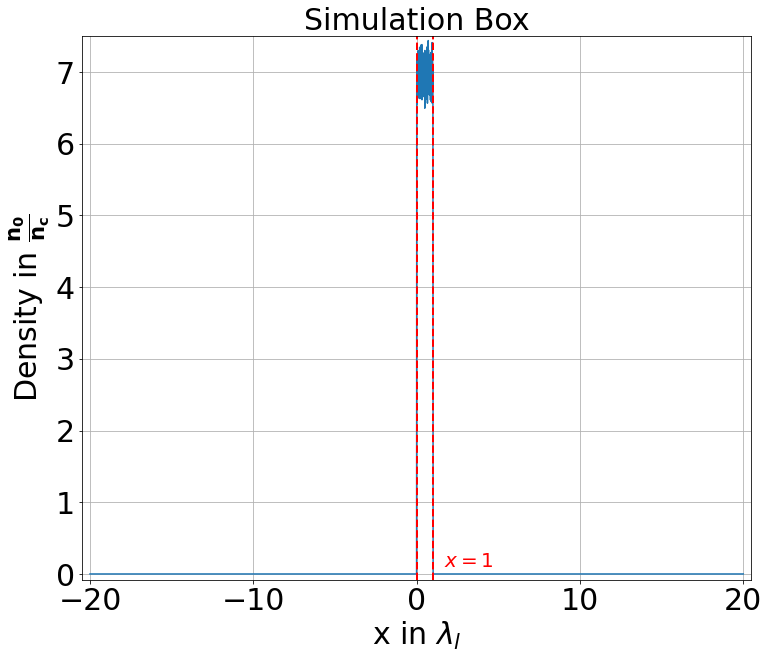

In [34]:
plt.figure(figsize=(12, 10))
plt.plot(X, data.Derived_Number_Density_Electron.data/nc)
plt.axvline(0, linestyle = "--", color="red", linewidth=2)
# plt.annotate("$x=0$", (-2.7, 0.1), color="red", fontsize=20)
plt.axvline(1, linestyle = "--", color="red", linewidth=2)
plt.annotate("$x=1$", (1.7, 0.1), color="red", fontsize=20)
plt.xlim(-20.5, 20.5)
plt.ylim(-0.08, 7.5)
plt.title("Simulation Box", fontsize=30)
plt.xlabel("x in $\lambda_l$", fontsize=30)
plt.ylabel(r"Density in $\mathbf{\frac{n_0}{n_c}}$", fontsize=30)
plt.grid("both")
file_name = "plasma.jpg"
plt.savefig(os.path.join(SAVE_DIR, file_name), dpi=200)
# plt.xticks(np.arange(-10, 10, 2),fontsize=20)
# plt.yticks(fontsize=20);